# OAK Model Grid
Interactive Python notebook which trains an OAK model and plots the components.

In [59]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [60]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return np.sin(x1*2) + 3*x2**3 + x1*np.sin(x2*2)


# --- Define the true components ---
true_f1 = lambda x: np.sin(2*x)
true_f2 = lambda x: 3*x**3
true_f12 = lambda X: X[:,0]*np.sin(2*X[:,1])


n = 1000
noise = 0.01
X = np.random.normal(0, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)
y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std

In [62]:
# --- Create OAK model ---
data = (X, y)
oak = create_model_oak(
    data=data,
    max_interaction_depth=2,
    constrain_orthogonal=True,
    share_var_across_orders=True,
    use_sparsity_prior=False,
)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(oak.training_loss, oak.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(oak)
print(f"Training NLL is {oak.training_loss()}")


╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   2.5075     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.56224    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.

In [64]:
N = 10000
X_samples = np.random.normal(0, 1, size=(N, 2))
X_train = oak.data[0].numpy()
alpha = get_model_sufficient_statistics(oak, get_L=False)
selected_dims, kernel_list = get_list_representation(oak.kernel, num_dims=2)



# --- Meshgrid for plotting ---
x1_plot = np.linspace(-1.5, 1.5, 100)
x2_plot = np.linspace(-1.5, 1.5, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)
X_grid_f1 = np.stack([X1_grid.ravel(), np.zeros_like(X1_grid).ravel()], axis=1)
X_grid_f1_tf = tf.convert_to_tensor(X_grid_f1, dtype=tf.float64)
X_grid_f2 = np.stack([np.zeros_like(X2_grid).ravel(), X2_grid.ravel()], axis=1)
X_grid_f2_tf = tf.convert_to_tensor(X_grid_f2, dtype=tf.float64)


# --- Build inputs with fixed variables for f1 and f2 ---
X_plot_f1 = np.copy(X_grid)
X_plot_f1[:, 1] = 0
X_plot_f2 = np.copy(X_grid)
X_plot_f2[:, 0] = 0
X_plot_f12 = X_grid


# --- Evaluate function ---
f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f12_vals = eval_component(kernel_list[3], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)



# --- Posterior Variances ---
K_yy = oak.kernel.K(X_train, X_train) + tf.eye(len(X_train), dtype=tf.float64) * oak.likelihood.variance.numpy()

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K_yy, X_grid_tf, X_train)
var_f0 = var_f0_tensor.numpy().reshape(100, 100)
std_f0 = np.sqrt(var_f0) * y_std

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K_yy, X_grid_f1_tf, X_train)
var_f1 = var_f1_tensor.numpy().reshape(100, 100)
std_f1 = np.sqrt(np.mean(var_f1, axis=0)) * y_std

# Variance for f2
var_f2_tensor = get_component_variance(kernel_list[2], K_yy, X_grid_f2_tf, X_train)
var_f2 = var_f2_tensor.numpy().reshape(100, 100)
std_f2 = np.sqrt(np.mean(var_f2, axis=0)) * y_std

# Variance for f12
var_f12_tensor = get_component_variance(kernel_list[3], K_yy, X_grid_tf, X_train)
var_f12 = var_f12_tensor.numpy().reshape(100, 100)
std_f12 = np.sqrt(var_f12) * y_std

# Variance for the overall model
var_overall_tensor = get_component_variance(oak.kernel, K_yy, X_grid_tf, X_train)
var_overall = var_overall_tensor.numpy().reshape(100, 100)
std_overall = np.sqrt(var_overall) * y_std



# --- Denorrmalise ---
#f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
f0_vals = f0_vals * y_std + y_mean
f1_vals = f1_vals * y_std
f2_vals = f2_vals * y_std
f12_vals = f12_vals * y_std
f_sum = f0_vals + f1_vals + f2_vals + f12_vals
f_true = true_function(X_grid).reshape(100,100)



# --- 1D plots of f1(x1), f2(x2) ---
f1_x1 = np.mean(f1_vals, axis=0)
f1_true = true_f1(x1_plot)
f2_x2 = np.mean(f2_vals, axis=1)
f2_true = true_f2(x2_plot)
f12_true = true_f12(X_grid).reshape(100,100)

f12_x1 = np.mean(f12_vals, axis=0)
f12_x2 = np.mean(f12_vals, axis=1)
f12_x1_true = np.mean(f12_true, axis=0)
f12_x2_true = np.mean(f12_true, axis=1)

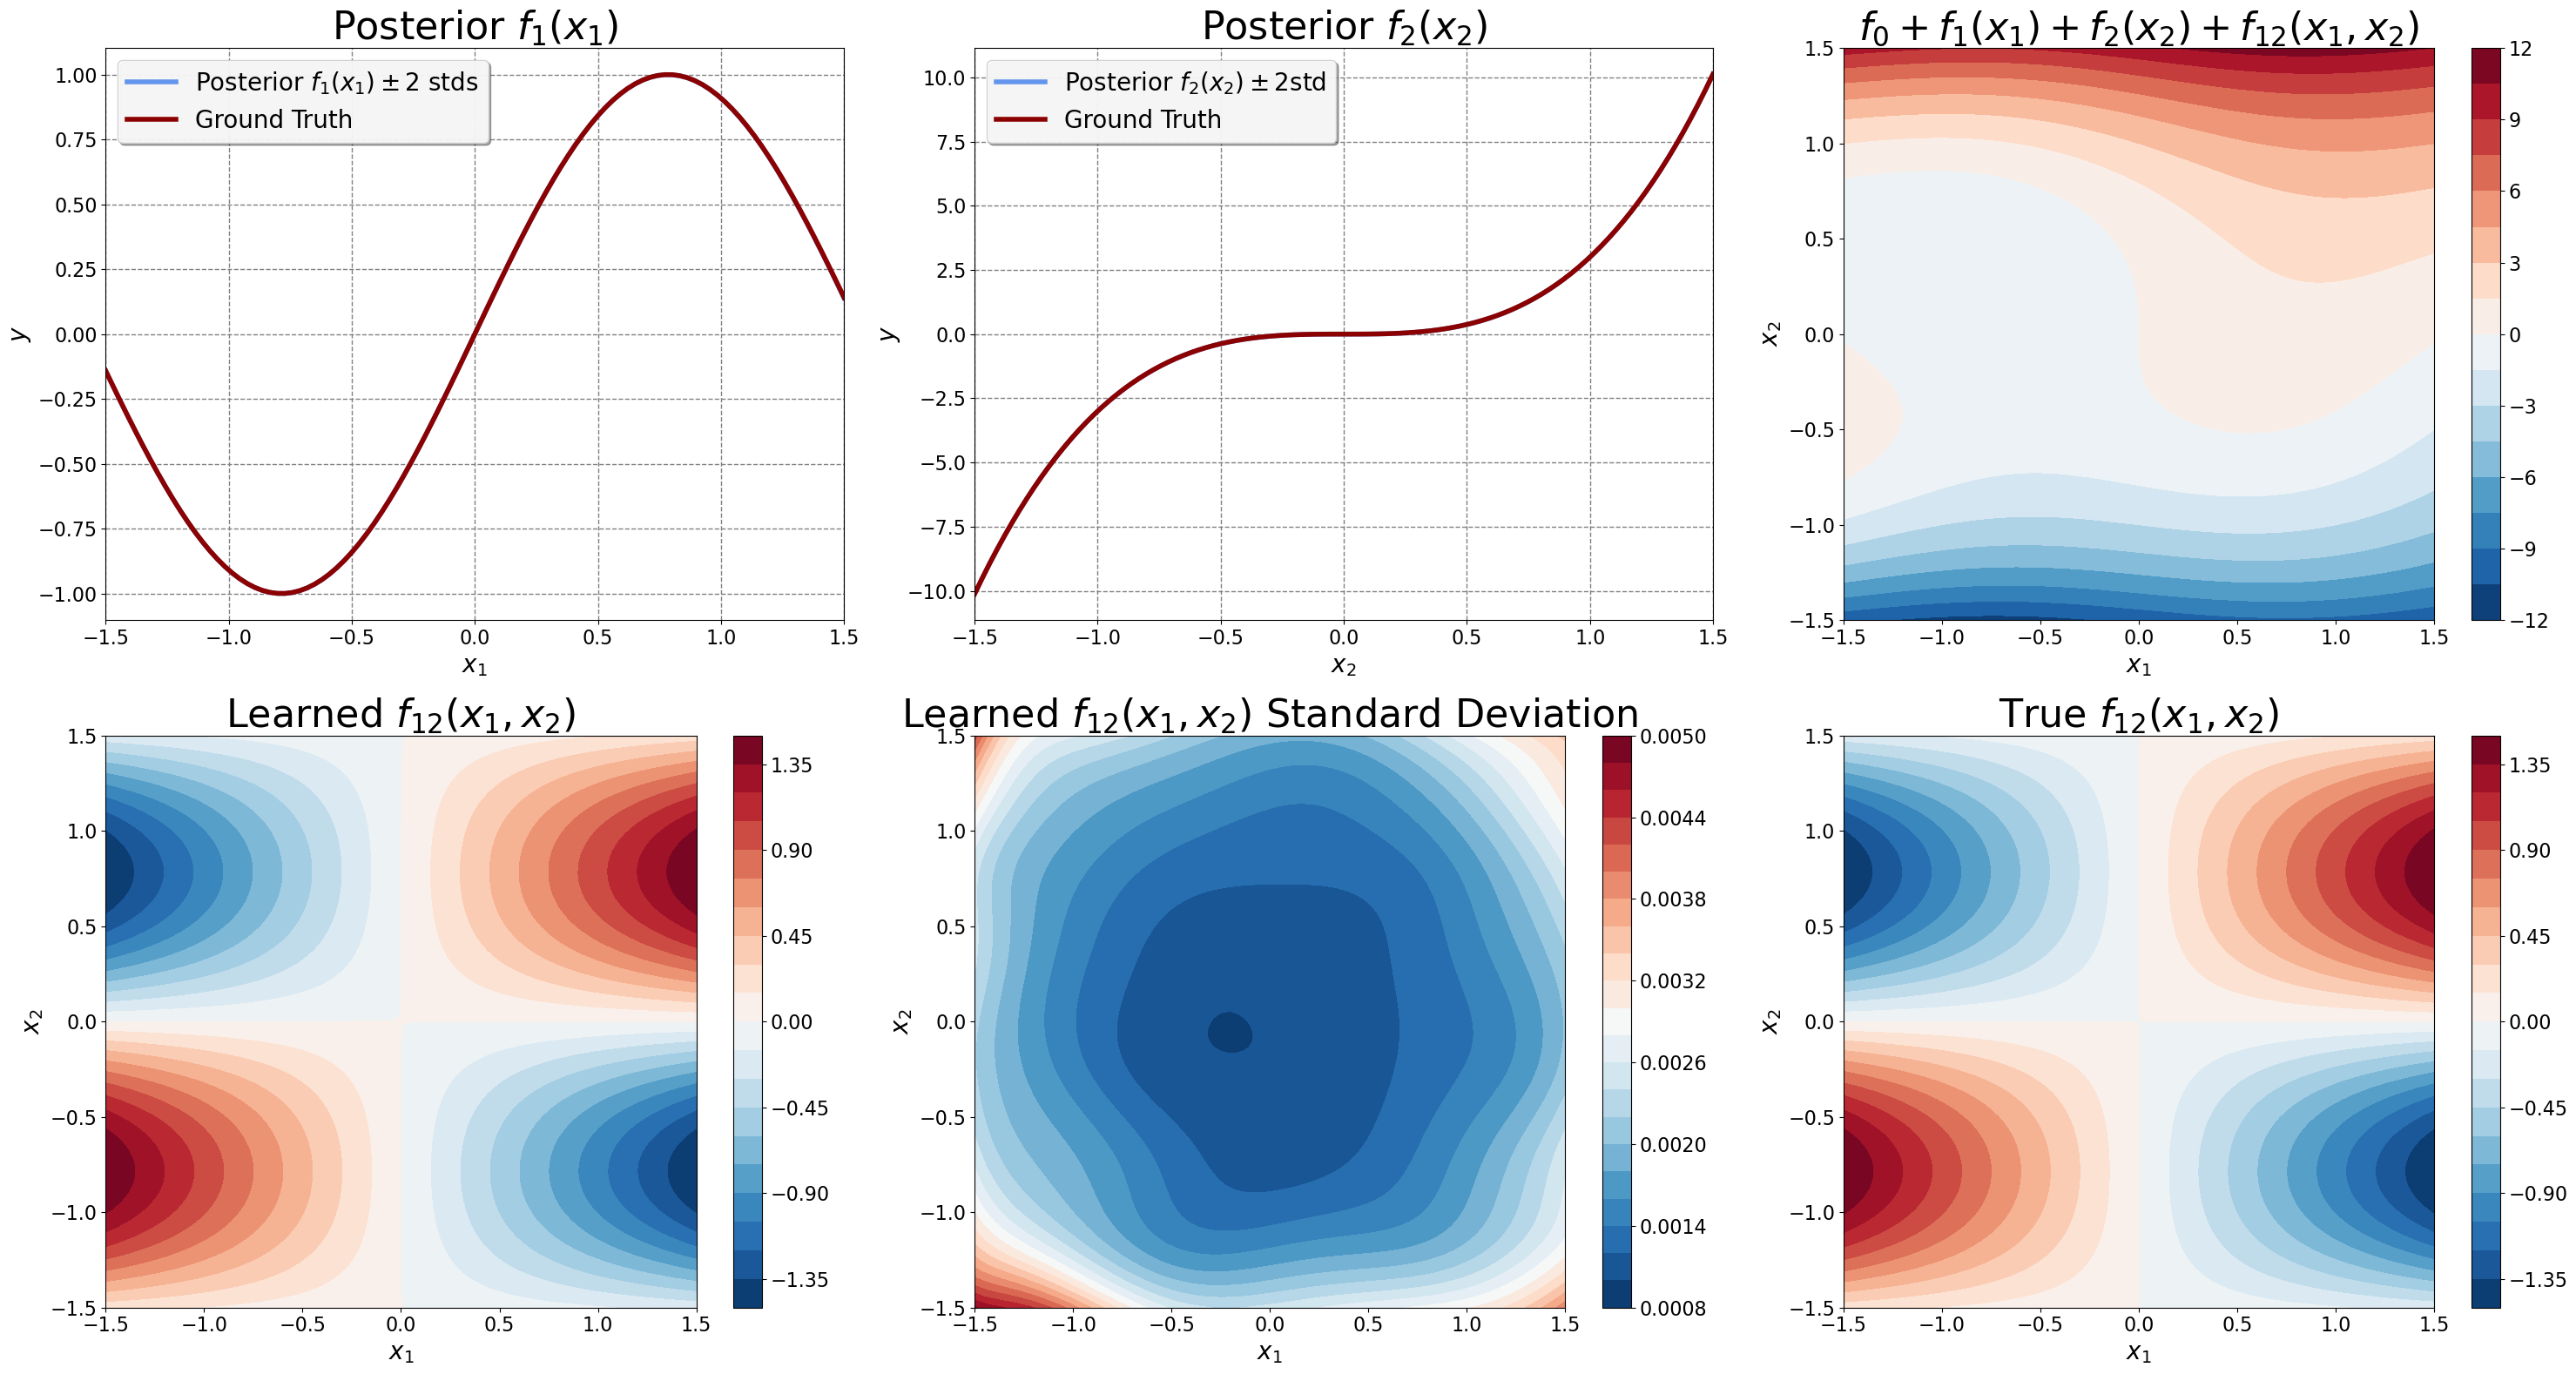

In [65]:
# --- Plot the results ---
fig, axes = plt.subplots(2, 3, figsize=(30, 16))

# f1
axes[0, 0].plot(x1_plot, f1_x1, label='Posterior $f_1(x_1) \\pm 2$ stds', color='cornflowerblue', linewidth=4)
axes[0, 0].fill_between(x1_plot, f1_x1 - 2*std_f1, f1_x1 + 2*std_f1, color='cornflowerblue', alpha=0.3)
axes[0, 0].plot(x1_plot, f1_true, label='Ground Truth', color='darkred', linewidth=4)
axes[0, 0].set_title("Posterior $f_1(x_1)$")
axes[0, 0].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('$y$')
axes[0, 0].set_xlim([-1.5,1.5])
axes[0, 0].grid(True)
axes[0, 0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f2
axes[0, 1].plot(x2_plot, f2_x2, label='Posterior $f_2(x_2) \\pm 2$std', color='cornflowerblue', linewidth=4)
axes[0, 1].fill_between(x2_plot, f2_x2 - 2*std_f2, f2_x2 + 2*std_f2, color='cornflowerblue', alpha=0.3)
axes[0, 1].plot(x2_plot, f2_true, label='Ground Truth', color='darkred', linewidth=4)
axes[0, 1].set_title("Posterior $f_2(x_2)$")
axes[0, 1].set_xlabel('$x_2$')
axes[0, 1].set_ylabel('$y$')
axes[0, 1].set_xlim([-1.5,1.5])
axes[0, 1].grid(True)
axes[0, 1].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f_total
cont2 = axes[0, 2].contourf(X1_grid, X2_grid, f_sum, levels=20, cmap='RdBu_r')
axes[0, 2].set_title("$f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1,x_2)$")
fig.colorbar(cont2, ax=axes[0, 2])
#axes[0, 2].set_xticks([])
#axes[0, 2].set_yticks([])
axes[0, 2].set_xlabel('$x_1$')
axes[0, 2].set_ylabel('$x_2$')


vmin = min(f12_vals.min(), f12_true.min())
vmax = max(f12_vals.max(), f12_true.max())


# Learned f12
cont = axes[1, 0].contourf(X1_grid, X2_grid, f12_vals, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1, 0].set_title("Learned $f_{12}(x_1, x_2)$")
fig.colorbar(cont, ax=axes[1, 0])
#axes[1, 0].set_xticks([])
#axes[1, 0].set_yticks([])
axes[1, 0].set_xlabel('$x_1$')
axes[1, 0].set_ylabel('$x_2$')

# Interaction Standard Deviation
cont3 = axes[1, 1].contourf(X1_grid, X2_grid, std_f12, levels=20, cmap='RdBu_r')
axes[1, 1].set_title("Learned $f_{12}(x_1, x_2)$ Standard Deviation")
fig.colorbar(cont3, ax=axes[1, 1])
#axes[1, 1].set_xticks([])
#axes[1, 1].set_yticks([])
axes[1, 1].set_xlabel('$x_1$')
axes[1, 1].set_ylabel('$x_2$')


# True f12
cont = axes[1, 2].contourf(X1_grid, X2_grid, f12_true, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1, 2].set_title("True $f_{12}(x_1, x_2)$")
fig.colorbar(cont, ax=axes[1, 2])
#axes[1, 2].set_xticks([])
#axes[1, 2].set_yticks([])
axes[1, 2].set_xlabel('$x_1$')
axes[1, 2].set_ylabel('$x_2$')




plt.tight_layout()
plt.show()

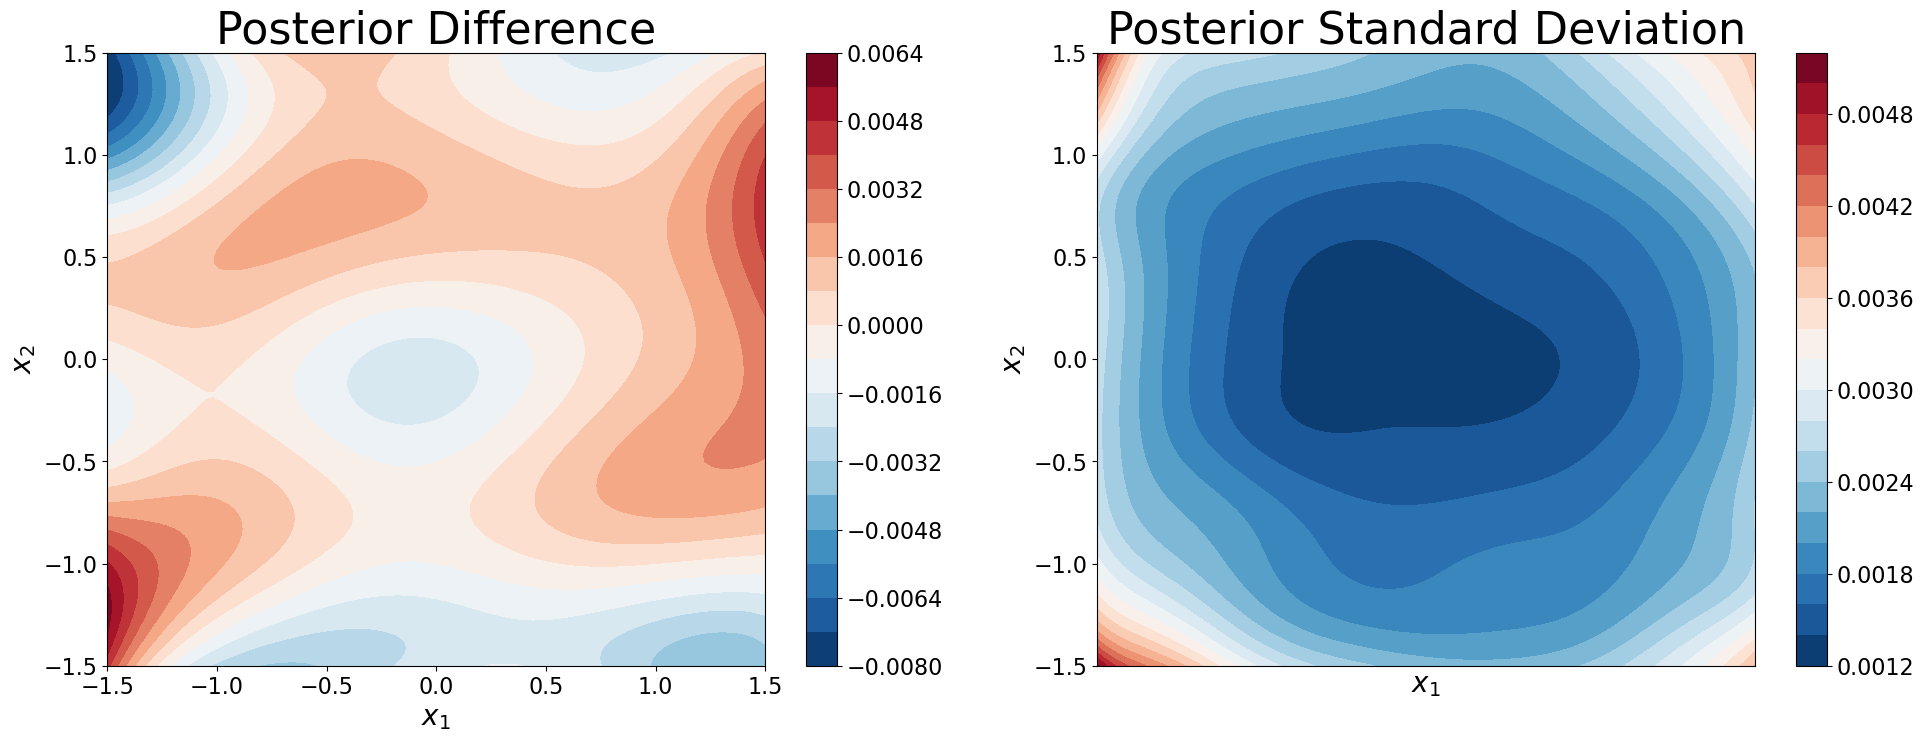

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Predictive Difference
cont3 = axes[0].contourf(X1_grid, X2_grid, f_true - f_sum, levels=20, cmap='RdBu_r')
axes[0].set_title("Posterior Difference")
fig.colorbar(cont3, ax=axes[0])
#axes[0].set_xticks([])
#axes[0].set_yticks([])
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')

# Predictive Difference
cont3 = axes[1].contourf(X1_grid, X2_grid, std_overall, levels=20, cmap='RdBu_r')
axes[1].set_title("Posterior Standard Deviation")
fig.colorbar(cont3, ax=axes[1])
axes[1].set_xticks([])
#axes[1].set_xticks([])
#axes[1].set_yticks([])
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')

plt.tight_layout(pad=2.0)
plt.show()

# Exponential Function

In [9]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return np.exp(-x1 + x2)


# --- Define the true components ---
true_f1 = lambda x: x*0
true_f2 = lambda x: x*0
true_f12 = lambda X: np.exp(-X[:,0] + X[:,1])


n = 1000
noise = 0.01
X = np.random.normal(0, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)
y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std

In [10]:
# --- Create OAK model ---
data = (X, y)
oak = create_model_oak(
    data=data,
    max_interaction_depth=2,
    constrain_orthogonal=True,
    share_var_across_orders=True,
    use_sparsity_prior=False,
)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(oak.training_loss, oak.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(oak)
print(f"Training NLL is {oak.training_loss()}")

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │            value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      3.56489     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      3.71382     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────

In [11]:
N = 10000
X_samples = np.random.normal(0, 1, size=(N, 2))
X_train = oak.data[0].numpy()
alpha = get_model_sufficient_statistics(oak, get_L=False)
selected_dims, kernel_list = get_list_representation(oak.kernel, num_dims=2)



# --- Meshgrid for plotting ---
x1_plot = np.linspace(-1.5, 1.5, 100)
x2_plot = np.linspace(-1.5, 1.5, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)
X_grid_f1 = np.stack([X1_grid.ravel(), np.zeros_like(X1_grid).ravel()], axis=1)
X_grid_f1_tf = tf.convert_to_tensor(X_grid_f1, dtype=tf.float64)
X_grid_f2 = np.stack([np.zeros_like(X2_grid).ravel(), X2_grid.ravel()], axis=1)
X_grid_f2_tf = tf.convert_to_tensor(X_grid_f2, dtype=tf.float64)


# --- Build inputs with fixed variables for f1 and f2 ---
X_plot_f1 = np.copy(X_grid)
X_plot_f1[:, 1] = 0
X_plot_f2 = np.copy(X_grid)
X_plot_f2[:, 0] = 0
X_plot_f12 = X_grid

y, var = oak.predict_f(X_grid)
y = y.numpy().reshape(100,100)*y_std + y_mean


# --- Evaluate function ---
f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f12_vals = eval_component(kernel_list[3], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)



# --- Denorrmalise ---
f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
f0_vals = f0_vals * y_std
f1_vals = f1_vals * y_std
f2_vals = f2_vals * y_std
f12_vals = f12_vals * y_std
f_true = true_function(X_grid).reshape(100,100)


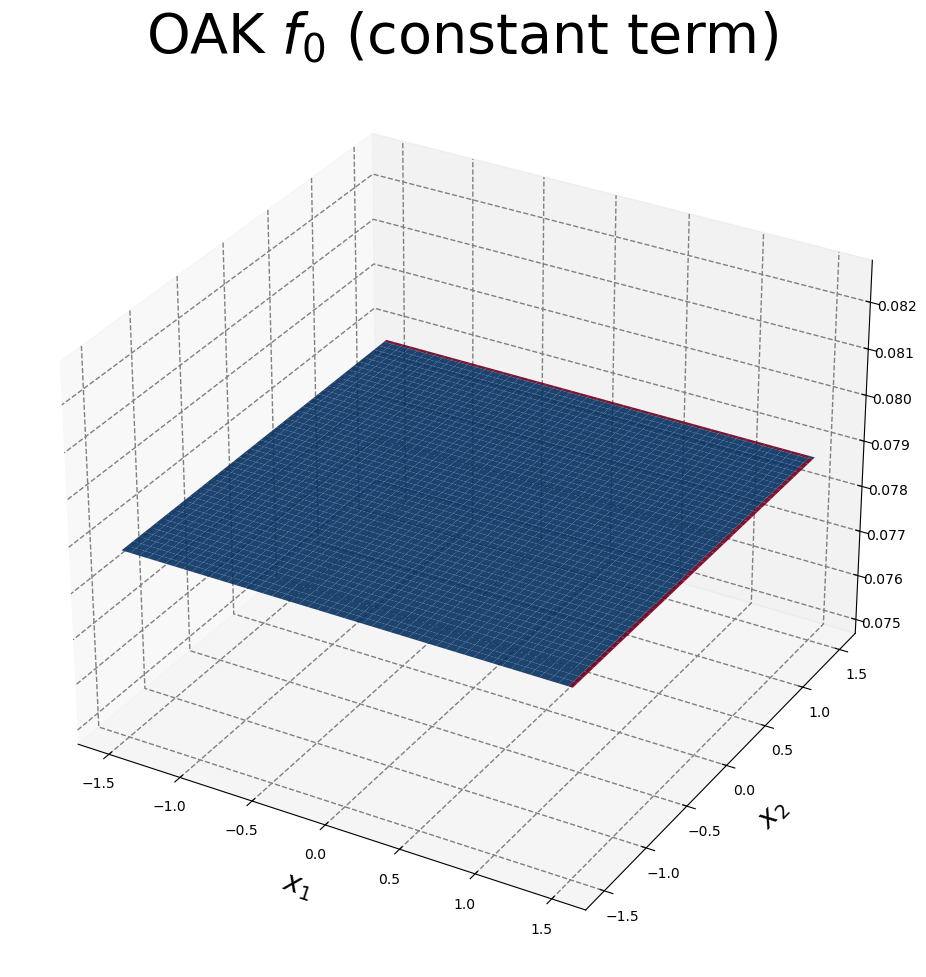

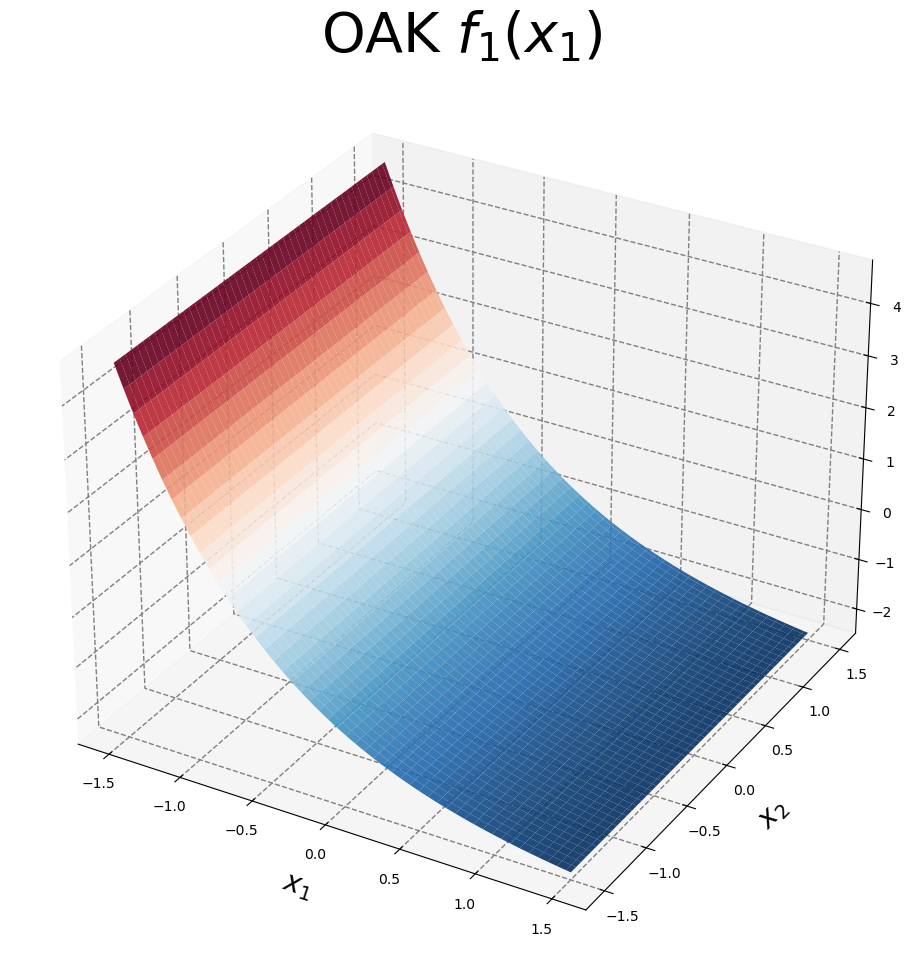

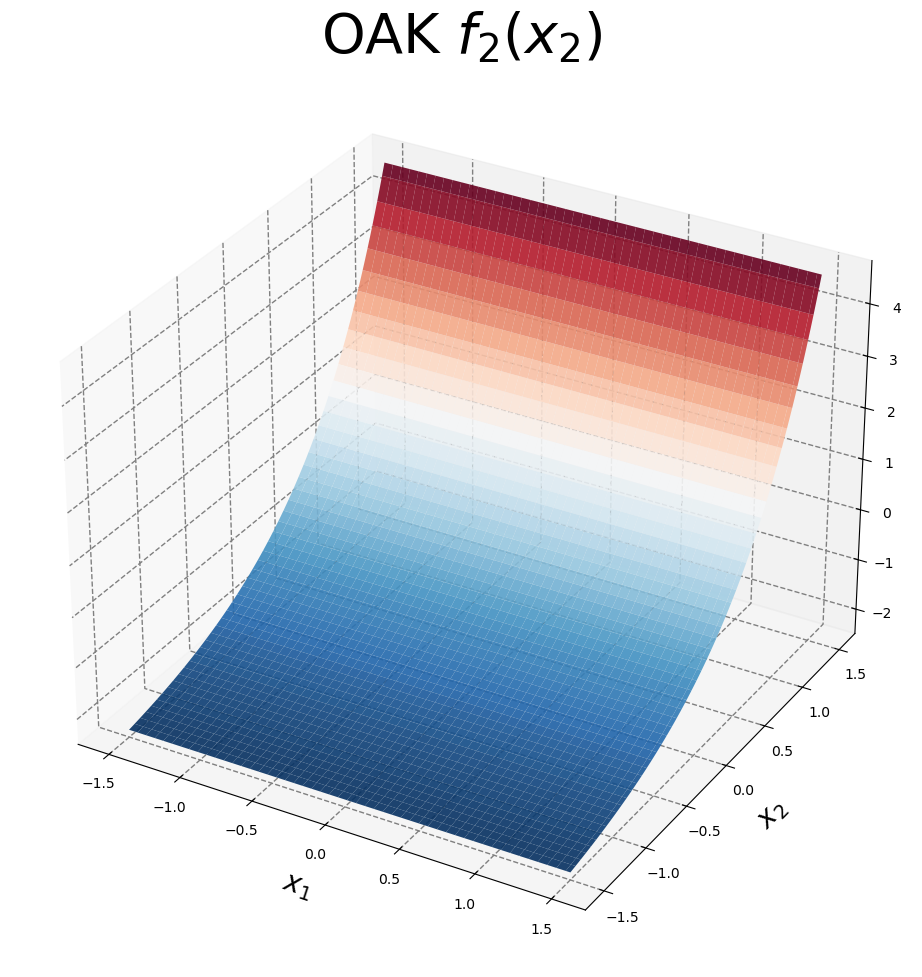

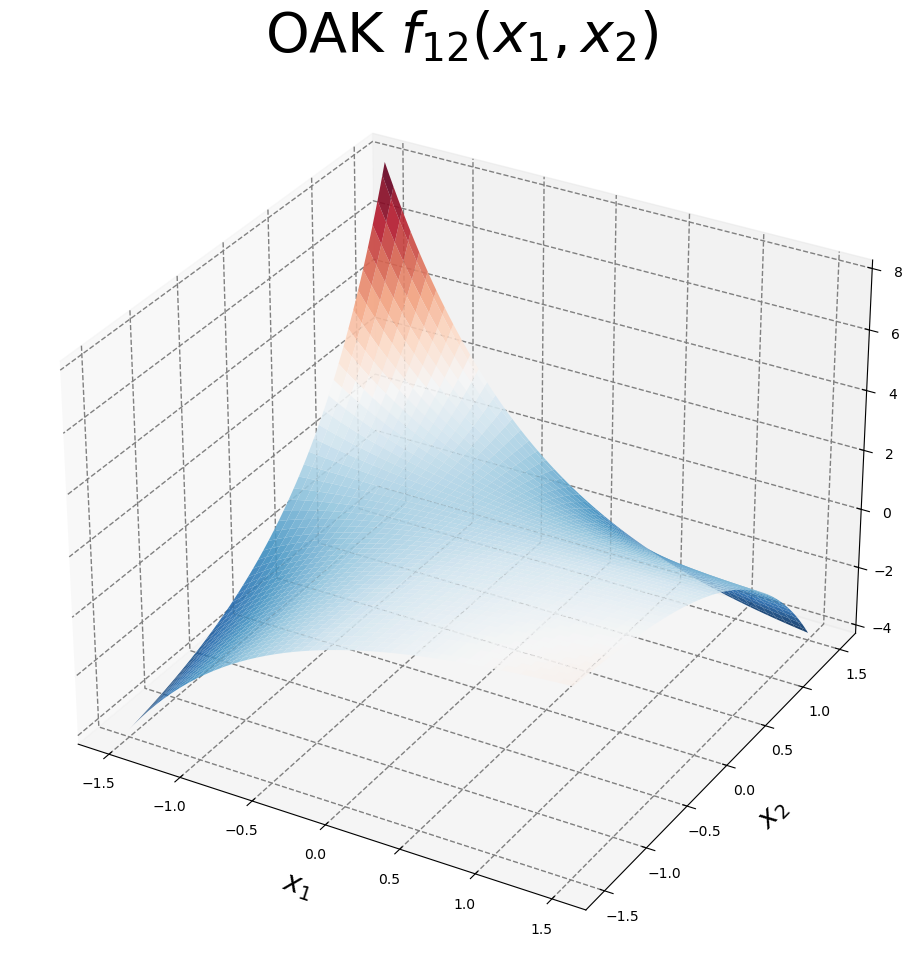

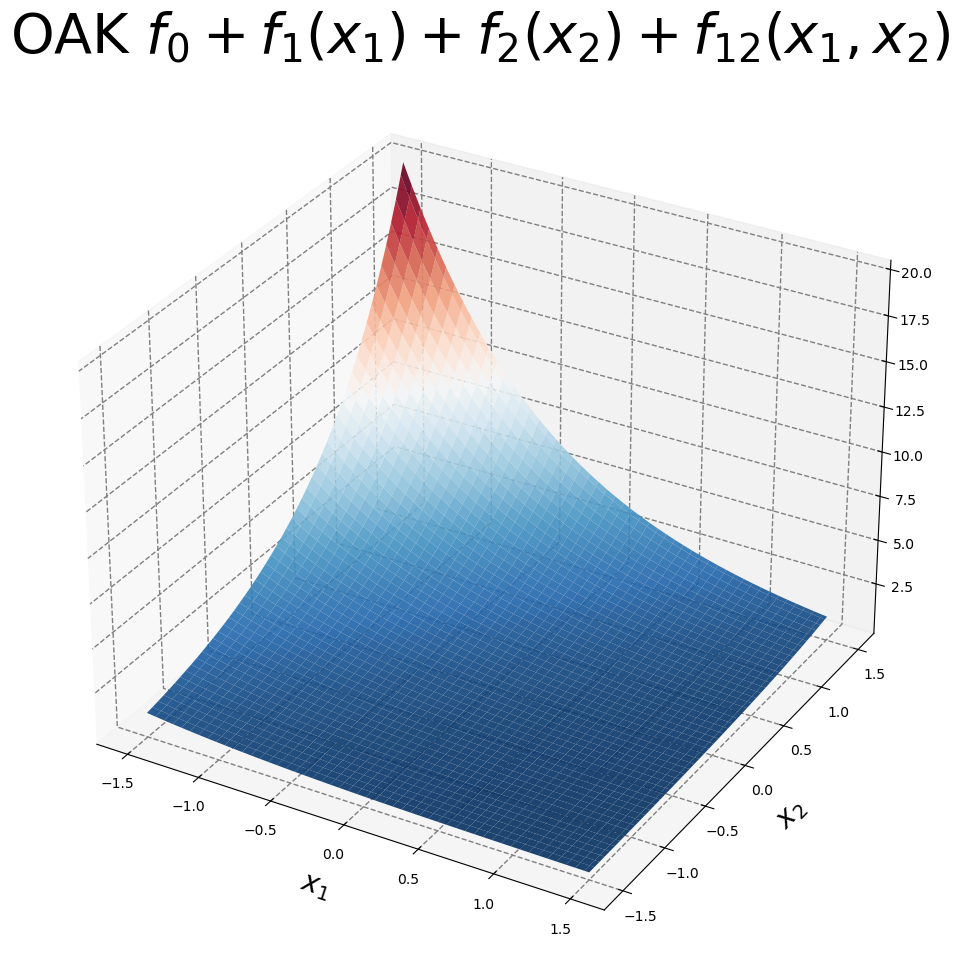

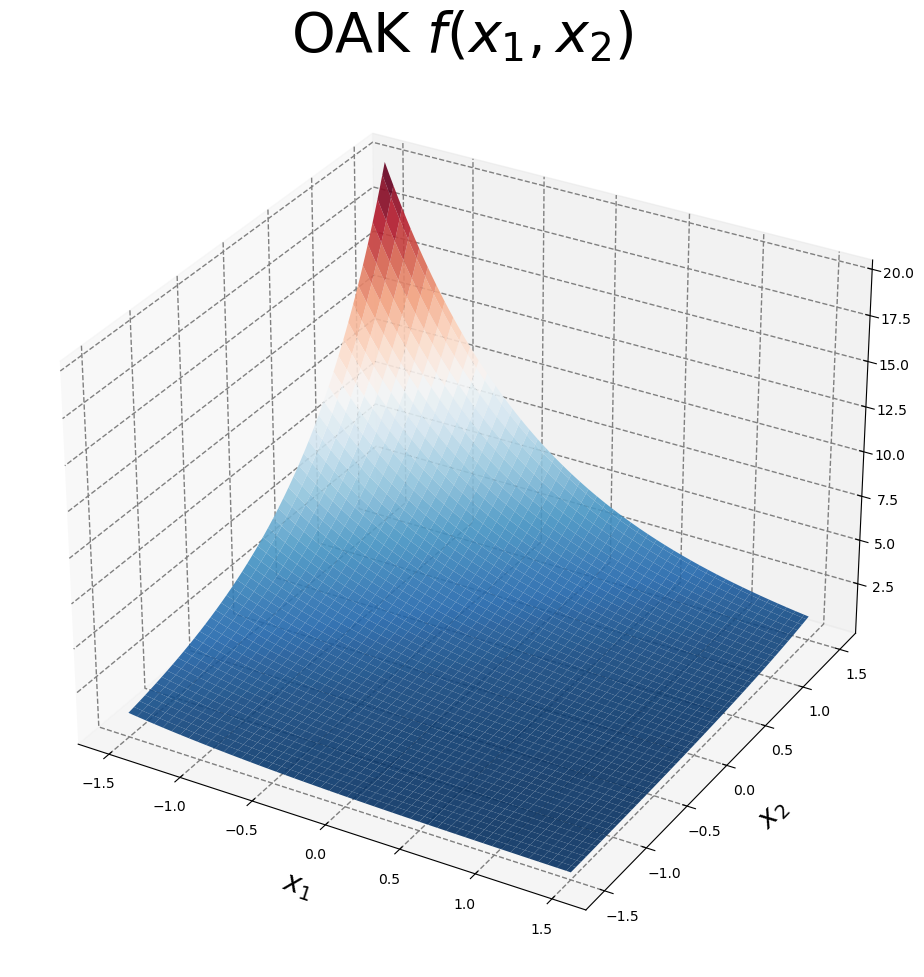

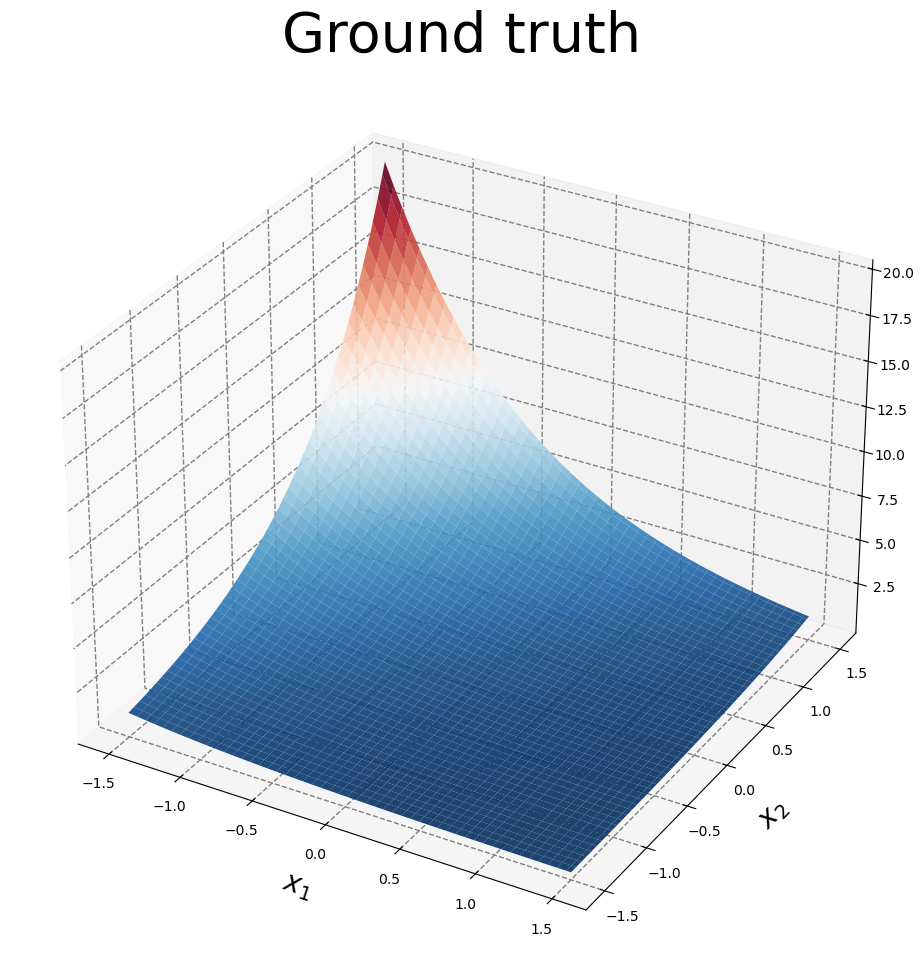

In [12]:
# --- Plot the functions ---
plot_3d_surface(X1_grid, X2_grid, f0_vals, title="OAK $f_0$ (constant term)", cmap="RdBu_r")
plot_3d_surface(X1_grid, X2_grid, f1_vals, title="OAK $f_1(x_1)$", cmap="RdBu_r")
plot_3d_surface(X1_grid, X2_grid, f2_vals, title="OAK $f_2(x_2)$", cmap="RdBu_r")
plot_3d_surface(X1_grid, X2_grid, f12_vals, title="OAK $f_{12}(x_1, x_2)$", cmap="RdBu_r")

plot_3d_surface(X1_grid, X2_grid, f_sum, title="OAK $f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1,x_2)$", cmap="RdBu_r")
plot_3d_surface(X1_grid, X2_grid, y, title="OAK $f(x_1, x_2)$", cmap="RdBu_r")
plot_3d_surface(X1_grid, X2_grid, f_true, title="Ground truth")